In [1]:
from tqdm import tqdm
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
import torchvision.transforms as transforms
from torchvision import datasets
from torchvision import transforms

from gudhi import CubicalComplex
from gudhi.sklearn.cubical_persistence import CubicalPersistence

import medmnist
from medmnist import INFO, Evaluator

from matplotlib import pyplot as plt

import time

In [2]:
from torch_cube_perslap_v2 import *

# Load PneumoniaMNIST from medmnist

In [3]:
data_flag = 'pneumoniamnist'
# data_flag = 'breastmnist'
download = True

NUM_EPOCHS = 3
BATCH_SIZE = 128
lr = 0.001

info = INFO[data_flag]
task = info['task']
n_channels = info['n_channels']
n_classes = len(info['label'])

DataClass = getattr(medmnist, info['python_class'])

In [4]:
# preprocessing
data_transform = transforms.Compose([
    transforms.ToTensor(),
    # transforms.Normalize(mean=[.5], std=[.5])
])

# load the data
train_dataset = DataClass(split='train', transform=data_transform, download=download)
test_dataset = DataClass(split='test', transform=data_transform, download=download)

pil_dataset = DataClass(split='train', download=download)

# encapsulate data into dataloader form
train_loader = data.DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True)
train_loader_at_eval = data.DataLoader(dataset=train_dataset, batch_size=2*BATCH_SIZE, shuffle=False)
test_loader = data.DataLoader(dataset=test_dataset, batch_size=2*BATCH_SIZE, shuffle=False)

Using downloaded and verified file: /Users/ruidong/.medmnist/pneumoniamnist.npz
Using downloaded and verified file: /Users/ruidong/.medmnist/pneumoniamnist.npz
Using downloaded and verified file: /Users/ruidong/.medmnist/pneumoniamnist.npz


In [5]:
print(train_dataset)
print("===================")
print(test_dataset)

Dataset PneumoniaMNIST of size 28 (pneumoniamnist)
    Number of datapoints: 4708
    Root location: /Users/ruidong/.medmnist
    Split: train
    Task: binary-class
    Number of channels: 1
    Meaning of labels: {'0': 'normal', '1': 'pneumonia'}
    Number of samples: {'train': 4708, 'val': 524, 'test': 624}
    Description: The PneumoniaMNIST is based on a prior dataset of 5,856 pediatric chest X-Ray images. The task is binary-class classification of pneumonia against normal. We split the source training set with a ratio of 9:1 into training and validation set and use its source validation set as the test set. The source images are gray-scale, and their sizes are (384−2,916)×(127−2,713). We center-crop the images and resize them into 1×28×28.
    License: CC BY 4.0
Dataset PneumoniaMNIST of size 28 (pneumoniamnist)
    Number of datapoints: 624
    Root location: /Users/ruidong/.medmnist
    Split: test
    Task: binary-class
    Number of channels: 1
    Meaning of labels: {'0': '

In [6]:
# visualization

train_dataset.montage(length=1)

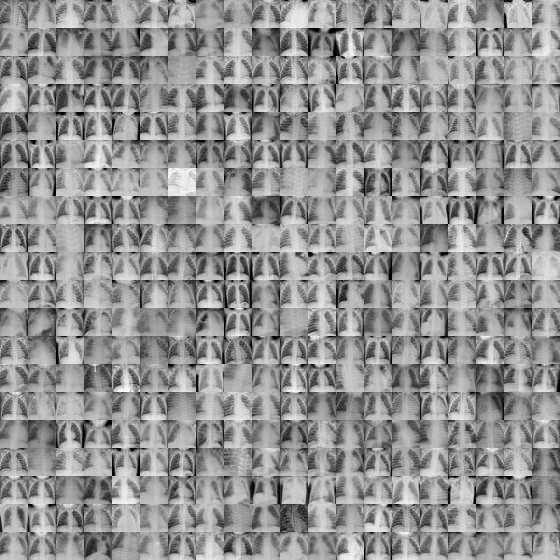

In [7]:
# montage

train_dataset.montage(length=20)

In [8]:
# Flip the training dataset and test dataset by convert img to 1 - img
train_dataset_flip = [(1 - img, _) for img, _ in train_dataset]
test_dataset_flip = [(1-img, _) for img, _ in test_dataset]

# Persistent Laplacian

## We load one image from training set to visualize

In [9]:
img, lb = train_dataset_flip[0]

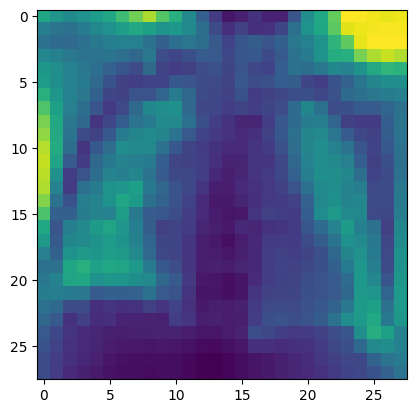

In [10]:
plt.imshow(img.permute(1, 2, 0))

In [11]:
# Set the basic parameters to compute eigenvalues of persistent Laplacians

cell_dim=1
start=0.2
end=1.0
steps=15
channel=0

eig_idx = 2

In [12]:
st = time.time()

tst_lap = perslap_eigs_pairs(img, cell_dim, start=start, end=end, steps=steps, channel=channel, eig_idx=eig_idx)

et = time.time()
print(et - st)

1.8176817893981934


In [13]:
tst_lap

[tensor([0.0108, 0.0256, 0.0557]),
 tensor([0.0106, 0.0202, 0.0287]),
 tensor([0.0040, 0.0057, 0.0134]),
 tensor([0.0040, 0.0055, 0.0133]),
 tensor([0.0043, 0.0059, 0.0140]),
 tensor([0.0040, 0.0054, 0.0144]),
 tensor([1.9713e-06, 2.5404e-06, 8.5694e-03]),
 tensor([-5.3372e-06, -4.9426e-06,  1.0811e-02]),
 tensor([-8.5203e-07,  1.1349e-02,  1.2657e-02]),
 tensor([0.0117, 0.0127, 0.0248]),
 tensor([0.0117, 0.0126, 0.0246]),
 tensor([0.0116, 0.0125, 0.0244]),
 tensor([0.0116, 0.0124, 0.0242]),
 tensor([0.0117, 0.0124, 0.0237])]

In [174]:
[lb for img, lb in train_dataset][0:10]

[array([1]),
 array([1]),
 array([1]),
 array([1]),
 array([1]),
 array([0]),
 array([1]),
 array([0]),
 array([1]),
 array([1])]

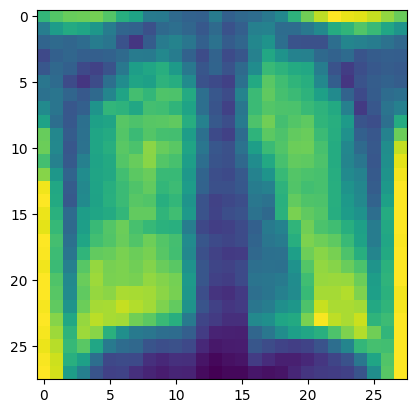

In [175]:
plt.imshow(img2.permute(1, 2, 0))

In [176]:
st = time.time()

tst_lap_2 = perslap_eigs_pairs(img2, cell_dim, start=start, end=end, steps=steps, channel=channel, eig_idx=eig_idx)

et = time.time()
print(et - st)

0.9045319557189941


In [193]:
st = time.time()

lap_egns_1 = [perslap_eigs_pairs(img, cell_dim, start=start, end=end, steps=steps, channel=channel, eig_idx=eig_idx) for img, _ in train_dataset_flip[0:500]]
# [perslap_eigs(img[0], cell_dim=cell_dim, start=start, end=end, steps=steps) for img in mnist2_flip[0:1000]]

et = time.time()
print(et - st)

821.9115438461304


In [205]:
torch_lap_egns_1 = torch.stack([torch.stack(eig_vals) for eig_vals in lap_egns_1])

In [206]:
torch.save(torch_lap_egns_1, "eigenvalues/lap_egns_1_pneum.pt")

In [207]:
st = time.time()

lap_egns_2 = [perslap_eigs_pairs(img, cell_dim, start=start, end=end, steps=steps, channel=channel, eig_idx=eig_idx) for img, _ in train_dataset_flip[500:1100]]
# [perslap_eigs(img[0], cell_dim=cell_dim, start=start, end=end, steps=steps) for img in mnist2_flip[0:1000]]

et = time.time()
print(et - st)

1015.6703500747681


In [208]:
torch_lap_egns_2 = torch.stack([torch.stack(eig_vals) for eig_vals in lap_egns_2])

In [209]:
torch.save(torch_lap_egns_2, "eigenvalues/lap_egns_2_pneum.pt")

In [210]:
st = time.time()

lap_egns_3 = [perslap_eigs_pairs(img, cell_dim, start=start, end=end, steps=steps, channel=channel, eig_idx=eig_idx) for img, _ in train_dataset_flip[1100:3000]]
# [perslap_eigs(img[0], cell_dim=cell_dim, start=start, end=end, steps=steps) for img in mnist2_flip[0:1000]]

et = time.time()
print(et - st)

3647.2617752552032


In [211]:
torch_lap_egns_3 = torch.stack([torch.stack(eig_vals) for eig_vals in lap_egns_3])

In [212]:
torch.save(torch_lap_egns_3, "eigenvalues/lap_egns_3_pneum.pt")

In [213]:
st = time.time()

lap_egns_4 = [perslap_eigs_pairs(img, cell_dim, start=start, end=end, steps=steps, channel=channel, eig_idx=eig_idx) for img, _ in train_dataset_flip[3000:3900]]
# [perslap_eigs(img[0], cell_dim=cell_dim, start=start, end=end, steps=steps) for img in mnist2_flip[0:1000]]

et = time.time()
print(et - st)

1512.3712220191956


In [ ]:
torch_lap_egns_4 = torch.stack([torch.stack(eig_vals) for eig_vals in lap_egns_4])

In [215]:
torch.save(torch_lap_egns_4, "eigenvalues/lap_egns_4_pneum.pt")

In [216]:
st = time.time()

lap_egns_5 = [perslap_eigs_pairs(img, cell_dim, start=start, end=end, steps=steps, channel=channel, eig_idx=eig_idx) for img, _ in train_dataset_flip[3900:]]
# [perslap_eigs(img[0], cell_dim=cell_dim, start=start, end=end, steps=steps) for img in mnist2_flip[0:1000]]

et = time.time()
print(et - st)

1332.317579984665


In [217]:
torch_lap_egns_5 = torch.stack([torch.stack(eig_vals) for eig_vals in lap_egns_5])

In [218]:
torch.save(torch_lap_egns_5, "eigenvalues/lap_egns_5_pneum.pt")

In [223]:
len(test_dataset_flip)

624

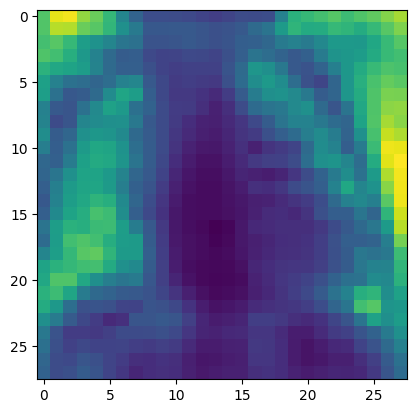

In [224]:
plt.imshow(test_dataset_flip[0][0].permute(1, 2, 0))

In [225]:
st = time.time()

lap_egns_test = [perslap_eigs_pairs(img, cell_dim, start=start, end=end, steps=steps, channel=channel, eig_idx=eig_idx) for img, _ in test_dataset_flip]
# [perslap_eigs(img[0], cell_dim=cell_dim, start=start, end=end, steps=steps) for img in mnist2_flip[0:1000]]

et = time.time()
print(et - st)

1053.0763268470764


In [227]:
torch_lap_egns_test = torch.stack([torch.stack(eig_vals) for eig_vals in lap_egns_test])

In [228]:
torch.save(torch_lap_egns_test, "eigenvalues/lap_egns_test_pneum.pt")

# Labels

In [240]:
train_labels = torch.stack([torch.tensor(lb) for img, lb in train_dataset])

In [241]:
torch.save(train_labels, "eigenvalues/train_labels_pneum.pt")

In [243]:
test_labels = torch.stack([torch.tensor(lb) for img, lb in test_dataset])

In [244]:
torch.save(test_labels, "eigenvalues/test_labels_pneum.pt")

In [69]:
import numpy as np
import sympy as sp
import scipy
from hodgelaplacians import HodgeLaplacians

In [70]:
from functions import rel_bdry_opr

In [50]:
def silly_Gaussian_elimination(A):
    """A is a numpy matrix, return the column Gaussian reduction of A using sympy."""
    m, n = np.shape(A)
    Y = np.eye(n)

    AY = np.concatenate((A, Y), axis=0)
    
    sp_AY_trans = sp.Matrix(AY.transpose(), dtype="float64")
    AY_gauss, _ = sp_AY_trans.rref()
    AY_gauss_trans = AY_gauss.transpose()

    AY_sparse = scipy.sparse.csr_matrix(np.array(AY_gauss_trans, dtype="float64"))
    return AY_sparse[0:m, 0:n], AY_sparse[m:m+n, 0:n]


In [51]:
img = train_dataset[0][0]
channel = 0

In [52]:
X = torch.tensor(CubicalComplex(top_dimensional_cells=img[channel, :, :]).all_cells(), dtype=torch.float32)
X = X.unsqueeze(0)

In [53]:
X

tensor([[[0.3608, 0.3608, 0.3608,  ..., 0.0235, 0.0235, 0.0235],
         [0.3608, 0.3608, 0.3608,  ..., 0.0235, 0.0235, 0.0235],
         [0.3608, 0.3608, 0.3608,  ..., 0.0078, 0.0118, 0.0118],
         ...,
         [0.6784, 0.6784, 0.6784,  ..., 0.5176, 0.5176, 0.5176],
         [0.6784, 0.6784, 0.6784,  ..., 0.5451, 0.5451, 0.5451],
         [0.6784, 0.6784, 0.6784,  ..., 0.5451, 0.5451, 0.5451]]])

In [54]:
bdy_opr = torch_boundary_opr_coo_sparse(X, channel=0, filt=0.8, cell_dim=1)

In [55]:
X_np = X.to_dense().squeeze().detach().numpy()

In [56]:
X_np

array([[0.36078432, 0.36078432, 0.36078432, ..., 0.02352941, 0.02352941,
        0.02352941],
       [0.36078432, 0.36078432, 0.36078432, ..., 0.02352941, 0.02352941,
        0.02352941],
       [0.36078432, 0.36078432, 0.36078432, ..., 0.00784314, 0.01176471,
        0.01176471],
       ...,
       [0.6784314 , 0.6784314 , 0.6784314 , ..., 0.5176471 , 0.5176471 ,
        0.5176471 ],
       [0.6784314 , 0.6784314 , 0.6784314 , ..., 0.54509807, 0.54509807,
        0.54509807],
       [0.6784314 , 0.6784314 , 0.6784314 , ..., 0.54509807, 0.54509807,
        0.54509807]], dtype=float32)

In [60]:
A, Y = silly_Gaussian_elimination(X_np)

In [62]:
A.toarray()

array([[1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [63]:
Y.toarray()

array([[ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
         1.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
         0.00000000e+00,  1.00000000e+00,  0.00000000e+00],
       [ 8.89625441e-02,  1.93996104e+00, -1.14900667e+00, ...,
         5.44382477e-02,  5.44382477e-02,  0.00000000e+00],
       ...,
       [-2.06045442e+00, -4.82549472e+00,  3.21736031e+00, ...,
        -3.76458246e+00, -3.76458246e+00,  0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
         0.00000000e+00,  0.00000000e+00,  1.00000000e+00],
       [-4.49621094e-13, -2.68258100e-12,  2.64028857e-12, ...,
        -4.99891011e-13, -4.99891011e-13, -1.00000000e+00]])

In [67]:
X_np @ Y

array([[ 1.00000000e+00, -1.31508717e-12,  1.09649511e-12, ...,
        -2.02843462e-13, -2.08488293e-13,  0.00000000e+00],
       [ 1.00000000e+00, -1.31508717e-12,  1.09649511e-12, ...,
        -2.02843462e-13, -2.08488293e-13,  0.00000000e+00],
       [ 6.37497446e-14,  1.00000000e+00,  1.10563307e-12, ...,
        -2.04276356e-13, -2.09019103e-13,  0.00000000e+00],
       ...,
       [ 4.69918057e-13, -5.31843365e-12,  4.30800881e-12, ...,
        -1.03861461e-12, -1.04661606e-12,  0.00000000e+00],
       [ 5.20848134e-13, -5.62286263e-12,  4.57602169e-12, ...,
        -1.10301952e-12, -1.11258747e-12,  0.00000000e+00],
       [ 5.20848134e-13, -5.62286263e-12,  4.57602169e-12, ...,
        -1.10301952e-12, -1.11258747e-12,  0.00000000e+00]])

In [73]:
tst_lap_up = torch_laplacian_up_coo_sparse(X, filt=0.7, channel=0, cell_dim=1)

In [74]:
tst_lap_up

tensor(indices=tensor([[   0,    0,    0,  ..., 1159, 1159, 1159],
                       [   0,   22,   23,  ..., 1153, 1154, 1159]]),
       values=tensor([ 1., -1.,  1.,  ...,  1., -1.,  1.]),
       size=(1160, 1160), nnz=7352, layout=torch.sparse_coo)

In [75]:
tst_lap_up.to_dense()

tensor([[1., 0., 0.,  ..., 0., 0., 0.],
        [0., 1., 0.,  ..., 0., 0., 0.],
        [0., 0., 1.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 1., 0., 0.],
        [0., 0., 0.,  ..., 0., 1., 0.],
        [0., 0., 0.,  ..., 0., 0., 1.]])

In [ ]:
torch.

In [103]:
torch_persistence_lap_up_v2(X, filt_1=0.6, filt_2=0.8, channel=0, cell_dim=1)

tensor([[ 1.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  1.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  1.0000,  ...,  0.0000,  0.0000,  0.0000],
        ...,
        [ 0.0000,  0.0000,  0.0000,  ...,  1.0000, -1.0000,  1.0000],
        [ 0.0000,  0.0000,  0.0000,  ..., -1.0000,  1.0000, -1.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  1.0000, -1.0000,  1.0000]])